In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("adult.csv")
df.columns = df.columns.str.replace("." , "_" )
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [4]:
# Replace missing values ("?") in workclass and occupation with "Unknown"
df['workclass'] = df['workclass'].replace('?', 'Unknown')
df["occupation"] = df["occupation"].replace('?', 'Unknown') 

df = df.loc[~df["workclass"].isin(["Never-worked", "Without-pay"])] 
# Drop rows where workclass is "Never-worked" or "Without-pay"
# because these categories are very rare and don't provide useful
# information for predicting income.


df["workclass"] = df["workclass"].replace({
    "Local-gov":"Goverment",
    "State-gov" : "Goverment", # Merge all types of government work into a single category "Government"
    "Federal-gov" : "Goverment"
})

df.drop(columns="fnlwgt" , inplace=True) # Drop fnlwgt (sampling weight), as it is not a predictive feature

df.loc[(df['education_num'] <= 8) | (df['education_num'] == 'Preschool'), 'education_num'] = 8
df.drop(columns="education" , inplace=True)
# Group all low education levels (<=8 years or Preschool) into one category "8"
# This simplifies the feature and avoids too many sparse categories


# Merge rare marital status categories:
# - "Married-AF-spouse" into "Married-civ-spouse"
# - "Married-spouse-absent" into "Separated"
df["marital_status"] = df["marital_status"].replace({
    "Married-AF-spouse" : "Married-civ-spouse",
    "Married-spouse-absent":"Separated", # add these feature to one groups
})

# Merge rare occupations to simplify categories:
# - Combine "Protective-serv" and "Armed-Forces" into "Protective/Armed"
# - Combine "Handlers-cleaners" and "Priv-house-serv" into "Other-service"
df["occupation"] = df["occupation"].replace({
    "Protective-serv":"Protective/Armed",
    "Armed-Forces" : "Protective/Armed",
    "Handlers-cleaners" : "Other-service",
    "Priv-house-serv":"Other-service"
})

# Simplify relationship: group "Not-in-family" and "Own-child" into "Single"

df["relationship"] = df["relationship"].replace({
    "Not-in-family" : "Single",
    "Own-child" : "Single"
})
# Group "Amer-Indian-Eskimo" into "Other" to reduce sparsity

df["race"] = df["race"].replace("Amer-Indian-Eskimo" ,"Other")

# Drop native_country since >90% of values are "United-States"
# It does not add much predictive power and may cause model bias
df.drop(columns="native_country" , inplace=True)

# Convert sex to numeric (Male=1, Female=0)
df["sex"] = df["sex"].replace({
    "Male":1,
    "Female":0
})

C:\Users\Arya\AppData\Local\Temp\ipykernel_5844\2677770862.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["workclass"] = df["workclass"].replace({
C:\Users\Arya\AppData\Local\Temp\ipykernel_5844\2677770862.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns="fnlwgt" , inplace=True) # Drop fnlwgt (sampling weight), as it is not a predictive feature
C:\Users\Arya\AppData\Local\Temp\ipykernel_5844\2677770862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

In [6]:
"""
Create a stratified train-test split 
(preserves target class distribution)
n_splits=10 -> generate 10 different splits (but we will just use the first one)
test_size=0.2 -> 20% of the data will be in the test set
"""
sss = StratifiedShuffleSplit(n_splits=10 , random_state=42 , test_size=0.2)
Stratifiedlist = []
for train_index , test_index in sss.split(df , df["income"]):
    sratified_train = df.iloc[train_index]
    sratified_test = df.iloc[test_index]

    Stratifiedlist.append([sratified_train ,sratified_test ])

train , test = Stratifiedlist[0]

In [7]:
X_train = train.drop(columns=["income"])
y_train = train["income"]
X_test = test.drop(columns=["income"])
y_test = test["income"]

In [8]:
# Convert target column (income) to numeric for better model performance
# '>50K' becomes 1, '<=50K' becomes 0
y_train = y_train.apply(lambda x: 1 if x == '>50K' else 0)
y_test = y_test.apply(lambda x: 1 if x == '>50K' else 0)

In [9]:
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.compose import ColumnTransformer

In [10]:
numeric = ["age" , "education_num" , "capital_gain","capital_loss","hours_per_week"]
categorical = ["workclass" , "marital_status" , "occupation" ,"relationship" , "race"]

In [11]:
preprocessor = ColumnTransformer(transformers=[
    ("num" , StandardScaler() , numeric),
    ("cat" , OneHotEncoder() , categorical),
])

X_train_t= preprocessor.fit_transform(X_train).toarray()
X_test_t= preprocessor.transform(X_test).toarray()

X_train = pd.DataFrame(X_train_t, columns=preprocessor.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(X_test_t, columns=preprocessor.get_feature_names_out(), index=X_test.index)

In [57]:
from sklearn.metrics import f1_score , recall_score , precision_score , ConfusionMatrixDisplay , accuracy_score,confusion_matrix,roc_curve, roc_auc_score

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
error_rate = []
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

In [ ]:
# Plot error rate for different values of K in KNN
# Helps us visually select the best n_neighbors (the K with the lowest error rate)
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [42]:
knn = KNeighborsClassifier(n_neighbors=36)

In [43]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=36)

In [44]:
knn_pred = knn.predict(X_test)

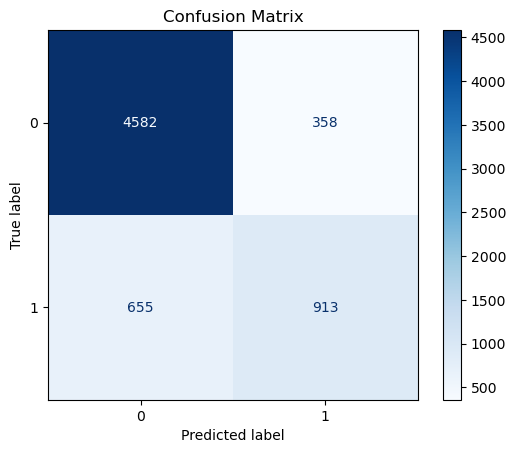

In [45]:
cm = confusion_matrix(y_test , knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
rfr = RandomForestClassifier(n_estimators=500 , max_depth=15)

In [20]:
rfr.fit(X_train , y_train)

RandomForestClassifier(max_depth=15, n_estimators=500)

In [21]:
rfr_pred = rfr.predict(X_test)

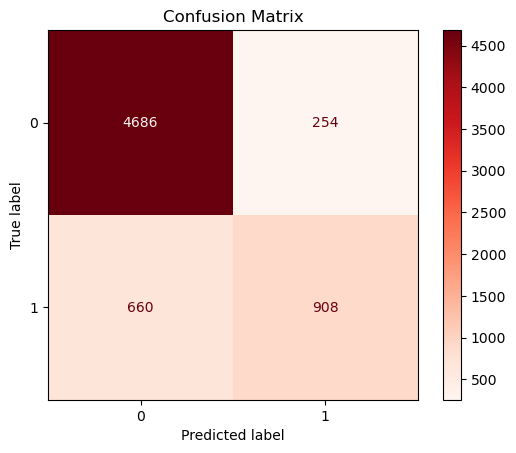

In [22]:
cm_rfr = confusion_matrix(y_test , rfr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rfr)
disp.plot(cmap='Reds')
plt.title('Confusion Matrix')
plt.show()

In [23]:
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=2000,
    max_depth=8,
    gamma=2,
    subsample=0.7,
    learning_rate=0.01,          
    colsample_bytree=0.85,        
    random_state=42,
    n_jobs=-1                    
)

In [25]:
xgb_model.fit(
    X_train, y_train,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000,
              n_jobs=-1, num_parallel_tree=None, ...)

In [26]:
xgb_pred = xgb_model.predict(X_test)

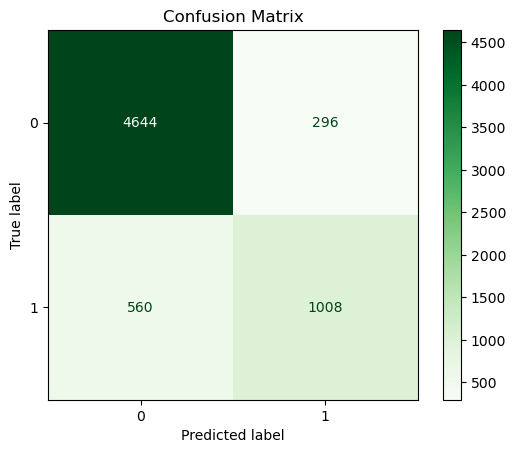

In [27]:
cm_xgb = confusion_matrix(y_test , xgb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot(cmap='Greens')
plt.title('Confusion Matrix')
plt.show()

In [28]:
from sklearn.svm import SVC

In [29]:
svc_model = SVC(kernel="rbf", class_weight="balanced")
svc_model.fit(X_train, y_train)

SVC(class_weight='balanced')

In [30]:
svc_pred = svc_model.predict(X_test)

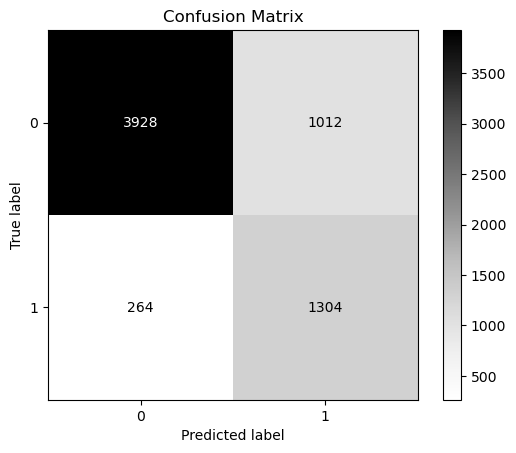

In [52]:
cm_svc = confusion_matrix(y_test , svc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc)
disp.plot(cmap='Grays')
plt.title('Confusion Matrix')
plt.show()

In [54]:
results = pd.DataFrame({
    "Model": ["KNN", "Random_Forest_Regression", "XGBoost", "SVC"],
    "Accuracy": [accuracy_score(y_test , knn_pred) ,accuracy_score(y_test , rfr_pred) , accuracy_score(y_test , xgb_pred),accuracy_score(y_test , svc_pred)],
    "F1-score": [f1_score(y_test , knn_pred) ,f1_score(y_test , rfr_pred) , f1_score(y_test , xgb_pred),f1_score(y_test , svc_pred)],
    "Precision_score" : [precision_score(y_test , knn_pred) ,precision_score(y_test , rfr_pred) , precision_score(y_test , xgb_pred),precision_score(y_test , svc_pred)],
    "Recall_score":[recall_score(y_test , knn_pred) ,recall_score(y_test , rfr_pred) , recall_score(y_test , xgb_pred),recall_score(y_test , svc_pred)]
})
results

,Model,Accuracy,F1-score,Precision_score,Recall_score
0,KNN,0.844345,0.643184,0.718332,0.582270
1,Random_Forest_Regression,0.859557,0.665201,0.781411,0.579082
2,XGBoost,0.868470,0.701950,0.773006,0.642857
3,SVC,0.803934,0.671473,0.563040,0.831633


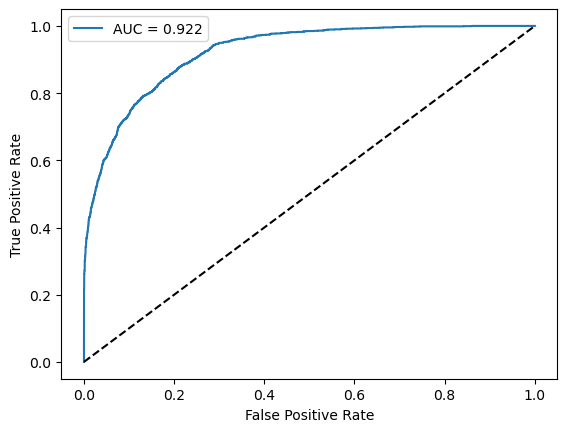

In [60]:
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
